In [ ]:
import numpy as np
from scipy.special import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
from tabulate import tabulate
from time import time

# Сам решатель Б-Ш

In [ ]:
def AnalyticBlackScholes(S, t, K, r, sigma):
  np.seterr(divide='ignore')
  if t==0:
    return np.maximum(S-K, 0)
  d_1 = (np.log(S/K) + (r + 0.5*(sigma**2))*t) / (sigma * np.sqrt(t))
  d_2 = (np.log(S/K) + (r - 0.5*(sigma**2))*t) / (sigma*np.sqrt(t))
  return S * norm.cdf(d_1) - K * np.exp(-r * t) * norm.cdf(d_2)

In [ ]:
def FBSsolverFDM(alpha, sigma, r, S_max, T, K, M, N):
  dS = S_max / N
  dt = T / M

  t = np.linspace(0, T, M+1)
  S = np.linspace(0, S_max, N+1)

  theta = 1 / (gamma(2 - alpha) * (dt ** alpha))

  b = np.zeros(M + 1)
  for j in range(M + 1):
    b[j] = (j + 1) ** (1 - alpha) - j ** (1 - alpha)

  A = -np.power(S * sigma / dS, 2) / 2 + (r * S) / (2 * dS)
  B = theta + np.power(S * sigma / dS, 2) + r
  C = -np.power(S * sigma / dS, 2) / 2 - (r * S) / (2 * dS)

  upper_diagonal = C[1:-2]
  central_diagonal = B[1:-1]
  lower_diagonal = A[2:-1]

  Matrix = np.diag(central_diagonal) + np.diag(upper_diagonal, 1) + np.diag(lower_diagonal, -1)
  Matrix_inv = np.linalg.inv(Matrix)

  U = np.zeros((M + 1, N + 1)) #Первый индекс по ВРЕМЕНИ, второй по ЦЕНЕ
  U[0, :] = np.maximum(S - K, 0)
  #U[:, -1] = S_max - K * np.exp(-r * t)
  for i in range(M+1):
    U[i, -1] = AnalyticBlackScholes(S_max, t[i], K, r, sigma)

  for j in range(1, M+1):
    R = U[0, 1:-1] * b[j-1]
    for k in range(1, j):
      R += (b[j - k - 1] - b[j - k]) * U[k, 1:-1]
    R *= theta
    R[-1] -= C[N - 1] * U[j, N]

    U[j, 1:-1] = np.dot(Matrix_inv, R)

  return U, t, S

# Всякие картинки и цифры

Считаю отклонение результата конечно-разностного метода от аналитического решения при разных $r, \sigma$. Ставить $\alpha = 1$ нельзя, см. ниже.

In [ ]:
alpha = 0.999999
S_max = 1000
T = 1
K = 500
M = 400
N = 400

r = np.arange(0, 0.101, 0.02)
sgm = np.arange(0, 1.01, 0.2)

headers = ["r\\sgm"] + [f"{x:.2f}" for x in sgm]

table = []
for a in r:
    row = [f"{a:.2f}"]
    for b in sgm:
        U, t, S = FBSsolverFDM(alpha, b, a, S_max, T, K, M, N)
        V = np.zeros_like(U)
        for i in range(t.shape[0]):
          V[i] = AnalyticBlackScholes(S, t[i], K, a, b)
        W = np.absolute(U-V)
        max_error = np.max(W[10:, :])
        row.append(f"{max_error:.4f}")
    table.append(row)

print(tabulate(table, headers=headers, tablefmt="grid", stralign="center"))

/tmp/ipython-input-15-414324963.py:5: RuntimeWarning: invalid value encountered in divide
  d_1 = (np.log(S/K) + (r + 0.5*(sigma**2))*t) / (sigma * np.sqrt(t))
/tmp/ipython-input-15-414324963.py:6: RuntimeWarning: invalid value encountered in divide
  d_2 = (np.log(S/K) + (r - 0.5*(sigma**2))*t) / (sigma*np.sqrt(t))


+---------+----------+--------+--------+--------+--------+--------+
|   r\sgm |     0.00 |   0.20 |   0.40 |   0.60 |   0.80 |   1.00 |
+=========+==========+========+========+========+========+========+
|    0    | nan      | 0.0989 | 0.167  | 0.242  | 0.319  | 0.3972 |
+---------+----------+--------+--------+--------+--------+--------+
|    0.02 |   0.7821 | 0.099  | 0.1671 | 0.2422 | 0.3192 | 0.3975 |
+---------+----------+--------+--------+--------+--------+--------+
|    0.04 |   0.9425 | 0.0989 | 0.1671 | 0.2423 | 0.3195 | 0.3978 |
+---------+----------+--------+--------+--------+--------+--------+
|    0.06 |   1.1359 | 0.0989 | 0.1672 | 0.2425 | 0.3198 | 0.3981 |
+---------+----------+--------+--------+--------+--------+--------+
|    0.08 |   1.2878 | 0.0988 | 0.1672 | 0.2426 | 0.32   | 0.3984 |
+---------+----------+--------+--------+--------+--------+--------+
|    0.1  |   1.4307 | 0.0986 | 0.1672 | 0.2427 | 0.3202 | 0.3988 |
+---------+----------+--------+--------+--------

Все то же самое, но $\alpha = 1$. Получаются совершенно неверные значения. Это ожидаемо, L-1 приближение при таком альфа вырождается в нечто бессмысленное.

In [ ]:
alpha = 1
S_max = 1000
T = 1
K = 500
M = 400
N = 400

r = np.arange(0, 0.101, 0.02)
sgm = np.arange(0, 1.01, 0.2)

headers = ["r\\sgm"] + [f"{x:.2f}" for x in sgm]

table = []
for a in r:
    row = [f"{a:.2f}"]
    for b in sgm:
        U, t, S = FBSsolverFDM(alpha, b, a, S_max, T, K, M, N)
        V = np.zeros_like(U)
        for i in range(t.shape[0]):
          V[i] = AnalyticBlackScholes(S, t[i], K, a, b)
        W = np.absolute(U-V)
        max_error = np.max(W[10:, :])
        row.append(f"{max_error:.4f}")
    table.append(row)

print(tabulate(table, headers=headers, tablefmt="grid", stralign="center"))

/tmp/ipython-input-15-414324963.py:5: RuntimeWarning: invalid value encountered in divide
  d_1 = (np.log(S/K) + (r + 0.5*(sigma**2))*t) / (sigma * np.sqrt(t))
/tmp/ipython-input-15-414324963.py:6: RuntimeWarning: invalid value encountered in divide
  d_2 = (np.log(S/K) + (r - 0.5*(sigma**2))*t) / (sigma*np.sqrt(t))


+---------+---------+---------+---------+---------+---------+---------+
|   r\sgm |    0.00 |    0.20 |    0.40 |    0.60 |    0.80 |    1.00 |
+=========+=========+=========+=========+=========+=========+=========+
|    0    | nan     | 463.236 | 443.101 | 444.44  | 459.061 | 479.367 |
+---------+---------+---------+---------+---------+---------+---------+
|    0.02 | 504.85  | 472.891 | 451.916 | 451.767 | 465.088 | 484.379 |
+---------+---------+---------+---------+---------+---------+---------+
|    0.04 | 514.399 | 482.35  | 460.618 | 459.051 | 471.082 | 489.364 |
+---------+---------+---------+---------+---------+---------+---------+
|    0.06 | 523.646 | 491.615 | 469.203 | 466.277 | 477.053 | 494.319 |
+---------+---------+---------+---------+---------+---------+---------+
|    0.08 | 532.59  | 500.689 | 477.678 | 473.441 | 482.986 | 499.245 |
+---------+---------+---------+---------+---------+---------+---------+
|    0.1  | 541.23  | 509.577 | 486.063 | 480.54  | 488.878 | 50

Неочевидно, но факт: при условии $r \neq 0$ ошибка концентрируется около точки $t=0, S=K$. Это странно, т.к. по идее около границы все наоборот должно быть супергуд, потому что сильно влияние граничных условий, но почему-то так происходит. Причина мне непонятна.

/tmp/ipython-input-15-414324963.py:5: RuntimeWarning: invalid value encountered in divide
  d_1 = (np.log(S/K) + (r + 0.5*(sigma**2))*t) / (sigma * np.sqrt(t))
/tmp/ipython-input-15-414324963.py:6: RuntimeWarning: invalid value encountered in divide
  d_2 = (np.log(S/K) + (r - 0.5*(sigma**2))*t) / (sigma*np.sqrt(t))


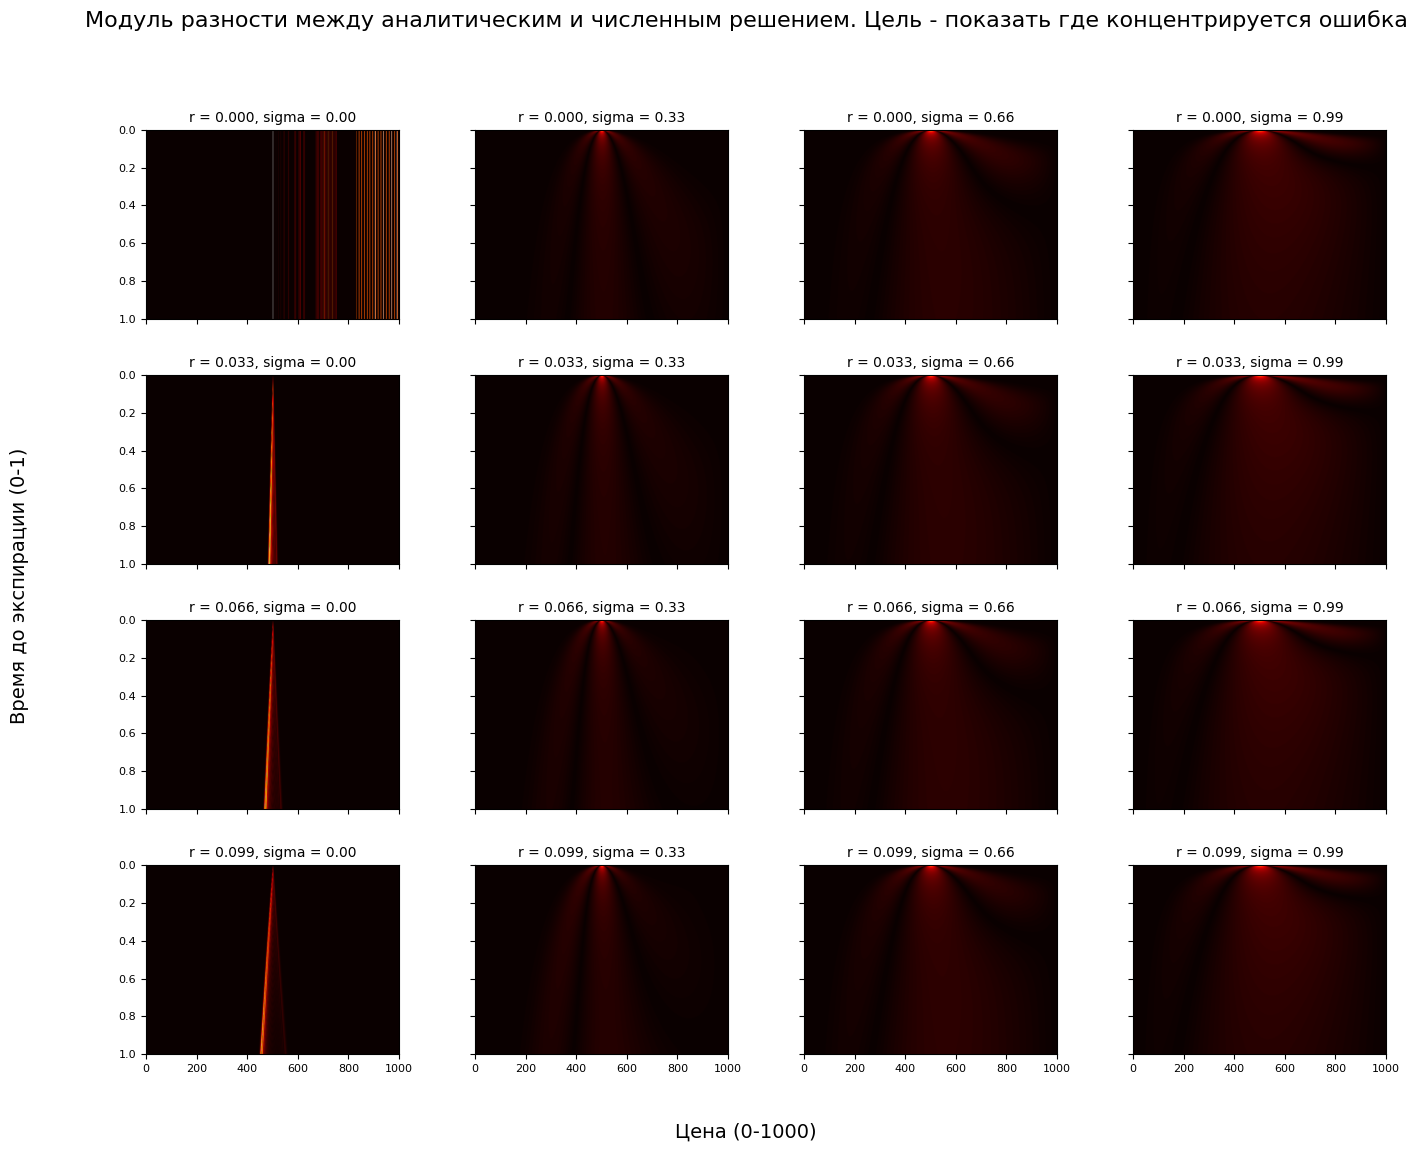

In [ ]:
alpha = 0.9999
S_max = 1000
T = 1
K = 500
M = 800
N = 800

A_vals = np.round([0.033 * i for i in range(4)], 3)
B_vals = np.round([0.33 * i for i in range(4)], 2)

fig, axs = plt.subplots(4, 4, figsize=(16, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i, a in enumerate(A_vals):
    for j, b in enumerate(B_vals):
        ax = axs[i, j]

        U, t, S = FBSsolverFDM(alpha, b, a, S_max, T, K, M, N)
        V = np.zeros_like(U)
        for k in range(t.shape[0]):
          V[k] = AnalyticBlackScholes(S, t[k], K, a, b)
        matrix = np.absolute(U-V)

        im = ax.imshow(matrix,
                       extent=[0, 1000, 1, 0],
                       origin='upper',
                       aspect='auto',
                       cmap='hot')

        ax.set_title(f'r = {a:.3f}, sigma = {b:.2f}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

fig.text(0.5, 0.04, 'Цена (0-1000)', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Время до экспирации (0-1)', va='center', rotation='vertical', fontsize=14)

plt.suptitle("Модуль разности между аналитическим и численным решением. Цель - показать где концентрируется ошибка", fontsize=16)
plt.show()

Посмотрим как ведет себя отклонение отклонение приближенных решений от аналитического при уменьшении шага сетки. Нам обещали сходимость порядка $O(\Delta S^2 + \Delta t^{1-\alpha})$, я здесь делаю по-тупому, и уменьшаю каждый раз шаг сетки и по S и по t, а $\alpha = 1$, так что должен получить сходимость порядка $O(\Delta t)$.

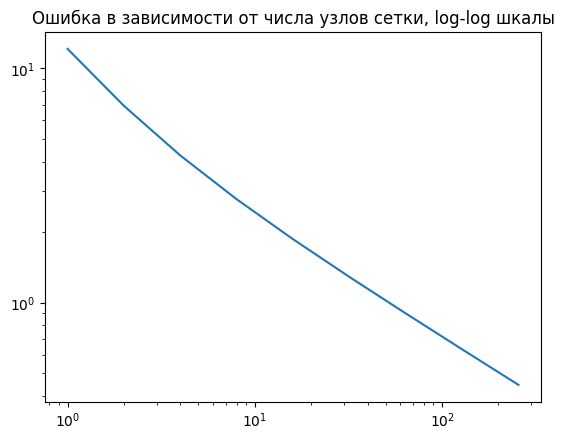

In [ ]:
alpha = 0.9999999
S_max = 1000
T = 1
K = 500
r = 0.1
sigma = 0.5

M_0 = 10
N_0 = 10

grid = np.power(2 * np.ones(9), np.arange(0, 9))
all_errors = np.zeros(9)

for i in range(9):
  U, t, S = FBSsolverFDM(alpha, b, a, S_max, T, K, M_0*int(grid[i]), N_0*int(grid[i]))
  V = np.zeros_like(U)
  for k in range(t.shape[0]):
    V[k] = AnalyticBlackScholes(S, t[k], K, a, b)
  W = np.absolute(U-V)
  all_errors[i] = np.max(W)

fig1, ax1 = plt.subplots()

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_title("Ошибка в зависимости от числа узлов сетки, log-log шкалы")

ax1.plot(grid, all_errors)

Посмотрим еще время работы. Я жестко поленился и не написал прогонку, а тупо обращаю несчастную трехдиагональную матрицу. На размерах типа 1000*1000 numpy еще не захлебывается, но за счет этого скорость можно улучшить.

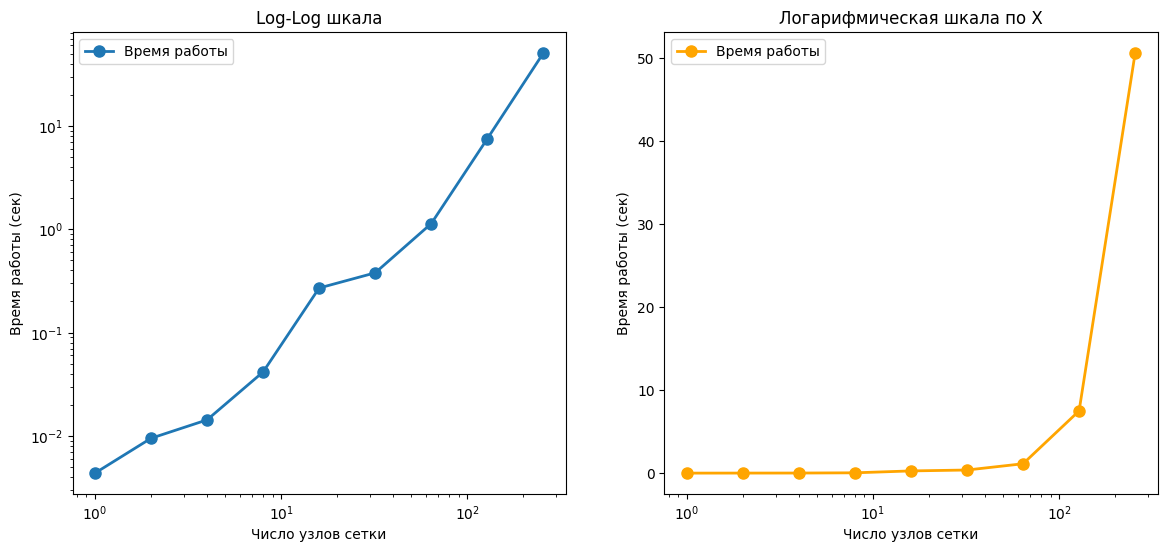

In [ ]:
alpha = 0.9999999
S_max = 1000
T = 1
K = 500
r = 0.1
sigma = 0.5

M_0 = 10
N_0 = 10

n = np.arange(0, 9)
sizes = np.power(2 * np.ones(9), np.arange(0, 9))
times = np.zeros(9)
for i in range(9):
  t1 = time()
  U, t, S = FBSsolverFDM(alpha, sigma, r, S_max, T, K, M_0*int(sizes[i]), N_0*int(sizes[i]))
  t2 = time()
  times[i] = t2 - t1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.loglog(sizes, times, 'o-', linewidth=2, markersize=8, label='Время работы')
ax1.set_title('Log-Log шкала')
ax1.set_xlabel('Число узлов сетки')
ax1.set_ylabel('Время работы (сек)')
ax1.legend()

ax2.semilogx(sizes, times, 'o-', color='orange', linewidth=2, markersize=8, label='Время работы')
ax2.set_title('Логарифмическая шкала по X')
ax2.set_xlabel('Число узлов сетки')
ax2.set_ylabel('Время работы (сек)')
ax2.legend()

plt.show()

Ну и посмотрим, как меняется решение при изменении альфа, меняется ли хоть что-то, и делает ли оно это непрерывно.

alpha = 0.9999


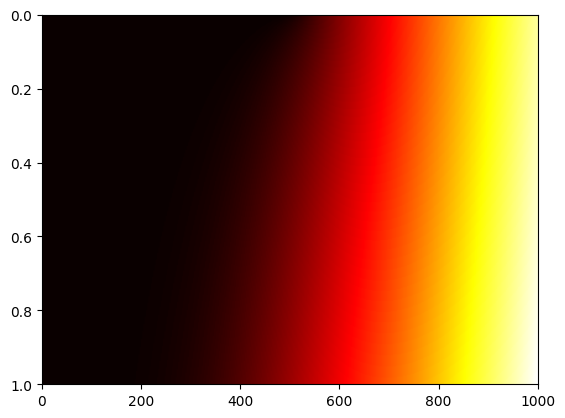

alpha = 0.8888


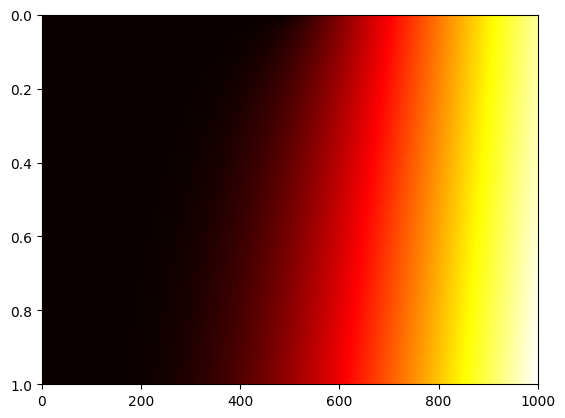

alpha = 0.7777000000000001


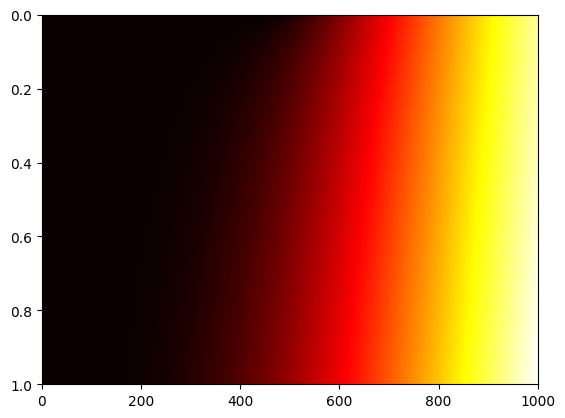

alpha = 0.6666000000000001


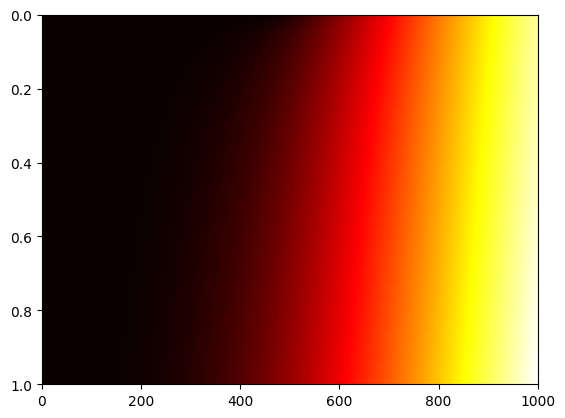

alpha = 0.5555


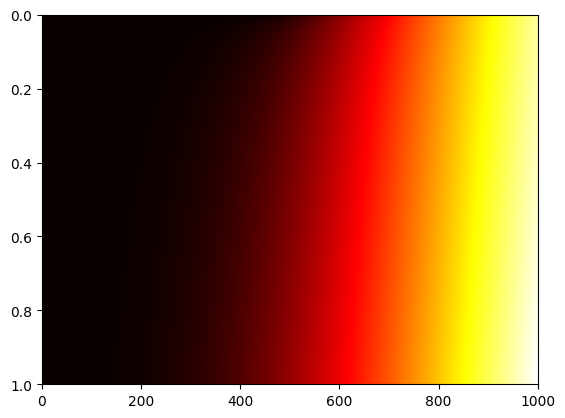

alpha = 0.4444


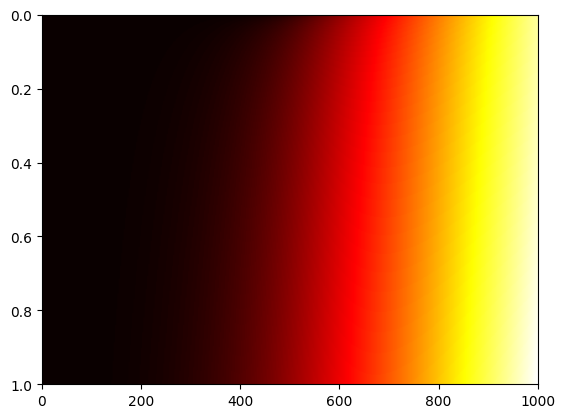

alpha = 0.33330000000000004


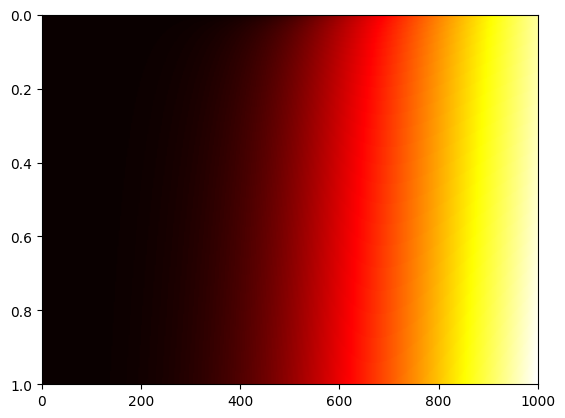

alpha = 0.2222


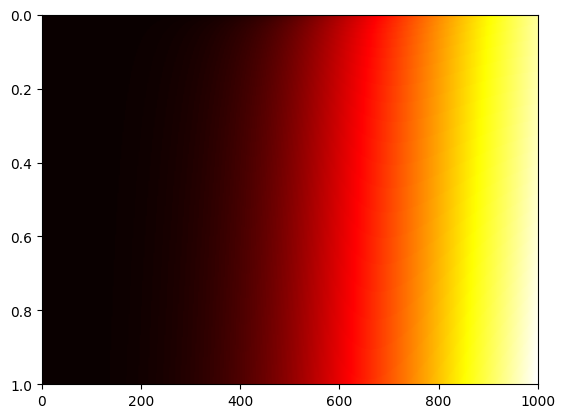

alpha = 0.1111


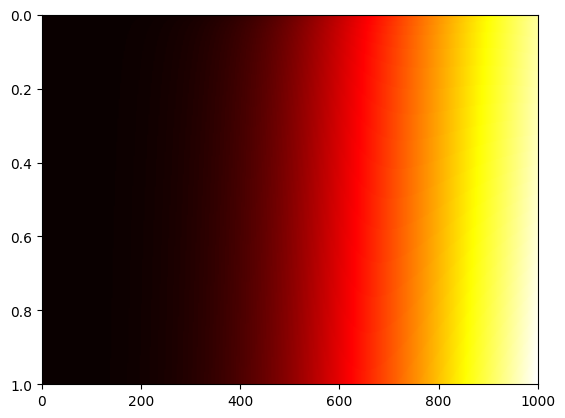

alpha = 0.0


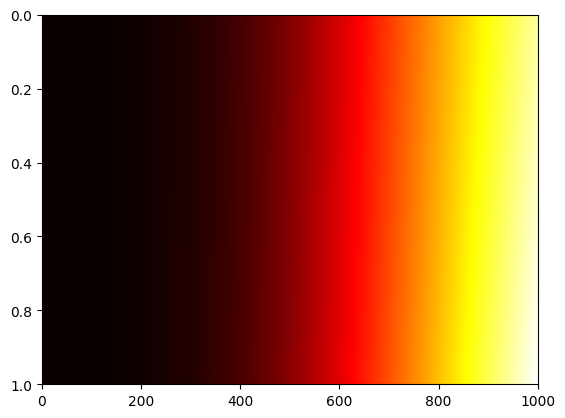

alpha = 0.9999


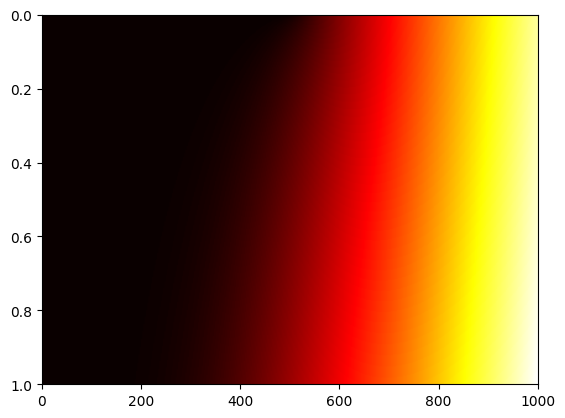

In [ ]:
def compute_matrix(alpha):
  S_max = 1000
  T = 1
  K = 500
  r = 0.1
  sigma = 0.5
  U, _, _ = FBSsolverFDM(alpha, sigma, r, S_max, T, K, 400, 400)
  return U

A = np.linspace(0, 1 - 1e-4, 10)
A = np.flip(A)
for alpha in A:
  U = compute_matrix(alpha)
  print(f"alpha = {alpha}")
  plt.imshow(U, extent=[0, 1000, 1, 0],
                       origin='upper',
                       aspect='auto',
                       cmap='hot')
  plt.show()

U = compute_matrix(0.9999)
print("alpha = 0.9999")
plt.imshow(U, extent=[0, 1000, 1, 0],
                       origin='upper',
                       aspect='auto',
                       cmap='hot')

plt.show()